Purpose:
The purpose of this file is to process data and conduct exploratory data analysis with more concentrated data points. Rather than looking at # of posts versus stock volatility in the most naive sense, we are splitting the social media posts into two separate data sets. 

For each stock, we define a "spike" in social media output as a day where the # of posts exceeds the 1.5 times the standard deviation of the posts for that stock. 
We choose to use a rolling weekly standard deviation to keep stocks in their temporal context. The choice of 1.5*standard deviation allows for a usable number of entries with spikes. By dividing the data into 1. the days where a stock does not have a spike in social media output and 2. the days where the stock does not have a spike in social, we may measure if extreme behavior has a more substantial effect on stock volatility. 

Conclusions from Exploratory Data Analysis: 
The distributions shown in the later parts of this document show the 

Step 1: Define Social Media Spikes
Identify spike days/weeks/months where social media post volume exceeds the rolling historical mean by more than two standard deviations, indicating statistically significant bursts of attention.

In [10]:
import pandas as pd

# Load and melt dataset to line up company social media output with stock tickers
df = pd.read_csv('bluesky_allkeywords.csv')

df_long = pd.melt(
    df,
    id_vars=['company'],
    var_name='date',
    value_name='all_keywords_mentions'
)
df_long['date'] = pd.to_datetime(df_long['date'])

# Mapping company to ticker explicitly
sp500_tickers = ["WMT", "AMZN", "AAPL", "CVS", "TSLA", "GOOGL", "META", "JPM", "COST", "KR",
"WBA", "TGT", "UPS", "CNC", "CI", "MSFT", "VZ", "IBM", "UNH", "XOM",
"MCK", "CVX", "CAH", "HD", "WBA", "MPC", "COR", "F", "C", "DELL",
"GM", "NVDA", "PFE", "PG", "CMCSA", "JNJ", "WFC", "BAC", "ABBV", "SBUX",
"CSCO", "T", "PEP", "INTC", "DIS", "BA", "GS", "MS", "HON", "CRM"
]
company_names = df_long['company'].unique()
company_to_ticker = dict(zip(company_names, sp500_tickers))
df_long['ticker'] = df_long['company'].map(company_to_ticker)

# Drop the original company column for clarity
df_long = df_long.drop(columns=['company'])

# Sort for rolling calculations in next cell
df_long = df_long.sort_values(['ticker', 'date']).reset_index(drop=True)


In [11]:
#Create a function that will separate the data into spikes vs no spikes. 

# Spike flagging function
def flag_spikes(df, window_size, count_col, flag_col):
    rolling_mean = df.groupby('ticker')[count_col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    rolling_std = df.groupby('ticker')[count_col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std().fillna(0))
   #1.5*rolling standard deviation
    df[flag_col] = df[count_col] > (rolling_mean + 1.5 * rolling_std)
    return df


# Daily spikes
df_long = flag_spikes(df_long, 7, 'all_keywords_mentions', 'daily_spike')
daily_spikes = df_long[df_long['daily_spike']][['date', 'ticker', 'all_keywords_mentions']]
print("Daily Spikes:\n", daily_spikes)

Daily Spikes:
             date ticker  all_keywords_mentions
11    2024-08-12   AAPL                   2176
25    2024-08-26   AAPL                   1538
32    2024-09-02   AAPL                   2591
39    2024-09-09   AAPL                   4854
65    2024-10-05   AAPL                   2361
...          ...    ...                    ...
18171 2025-07-02    XOM                     44
18179 2025-07-10    XOM                     42
18187 2025-07-18    XOM                     37
18188 2025-07-19    XOM                    108
18196 2025-07-27    XOM                     27

[1452 rows x 3 columns]


In [15]:
#Download stock data. 

import yfinance as yf
import numpy as np

#The 50 stocks of interest from the S&P 500 index
sp500_tickers = ["WMT", "AMZN", "AAPL", "CVS", "TSLA", "GOOGL", "META", "JPM", "COST", "KR",
"WBA", "TGT", "UPS", "CNC", "CI", "MSFT", "VZ", "IBM", "UNH", "XOM",
"MCK", "CVX", "CAH", "HD", "WBA", "MPC", "COR", "F", "C", "DELL",
"GM", "NVDA", "PFE", "PG", "CMCSA", "JNJ", "WFC", "BAC", "ABBV", "SBUX",
"CSCO", "T", "PEP", "INTC", "DIS", "BA", "GS", "MS", "HON", "CRM"
]


# Get the data for tickers from yahoo finance

# Download Close price data for tickers
stock_data_unordered = yf.download(sp500_tickers, '2023-01-01', '2025-10-02', auto_adjust=True)['Close']

# Download S&P 500 index data
SP500 = yf.download('^GSPC', '2023-01-01', '2025-10-02', auto_adjust=True)['Close']

# Transpose stock data so tickers are row index
stock_data_unordered = stock_data_unordered.T

# Reorder rows by original ticker list order
stock_data = stock_data_unordered.loc[sp500_tickers]
stock_data = stock_data.T

#log returns
log_returns= np.log(stock_data/stock_data.shift(1)).dropna()
SP500log_returns = np.log(SP500/SP500.shift(1)).dropna()

#Percentage change in stock returns day-to-day (in lieu of trading day variance)
sd2 = stock_data
pct_change = sd2.pct_change().dropna()
SP500_pct_change = SP500.pct_change().dropna()

#variance of stock returns over each week in the period (5 trading days) 
weekly_variance = log_returns.rolling(window=5).var().dropna()
SP500_weekly_variance = SP500log_returns.rolling(window=5).var().dropna()

#variance of stock returns over each 2 weeks in the period (10 trading days)
biweekly_variance = log_returns.rolling(window=10).var().dropna()
SP500_biweekly_variance = SP500log_returns.rolling(window=10).var().dropna()

#Note: variance windows are in trading days, not calendar days. Moreover, these are backwards looking rolling variances.

[*********************100%***********************]  49 of 49 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\3501509799.py:36: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_change = sd2.pct_change().dropna()


Step 2: Estimate Post-Spike Returns and Volatility

Objectives: 
The goal is now to measure out a prediction for a stock's daily percent change, or weekly/biweekly volatility, then compare it to it's actual value. This creates in-context notions of swings in the stock data. We also want to pair this with social media data for EVERY day and whether there is a spike. Since stock data is only available on trading days, this requires some additional engineering. 


Method:
For each day of social media output, we make an estimation for the each volatility for the next trading day/week/biweek., then compare it to the actual volatility using percent change. 

To estimate daily percent change in stock returns, use the rolling average daily returns for the previous 5 trading days. Note that this is not a perfect metric, as it ignores more sensitive market dynamics, but it will capture notably large swings in the temporal context.  
To estimate weekly volatility, use the rolling average weekly volatility for the previous 10 trading days.
To estimate monthly volatility, use the rolling average monthly volatility for the previous 20 trading days. 

In [16]:
##Code to get corresponding trading days before/after a given date
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np
# Load NYSE trading calendar
nyse = mcal.get_calendar('NYSE')


def get_trading_day_info(input_date, days_after, days_before):
    """
    Takes a datetime date and returns:
    1. The next trading day
    2. The 5th trading day after the date
    3. A list of trading days within 14 calendar days before the date
    """


 # Generate schedule around the target date
    schedule = nyse.schedule(start_date=date - pd.Timedelta(days=30), end_date=date + pd.Timedelta(days=30))
    trading_days = schedule.index


 # 1. Find the next trading day
    next_idx = trading_days.searchsorted(date, side='left')
    next_trading_day = trading_days[next_idx].date() if next_idx < len(trading_days) else None


    # 2. Find the nth trading day after
    nth_trading_day = trading_days[next_idx + days_after].date() if next_idx + (days_after) < len(trading_days) else None

    #3. Get all trading days within 14 days before the given date
    start_window = date - pd.Timedelta(days=days_before)
    trading_days_before = [d.date() for d in trading_days[(trading_days >= start_window) & (trading_days < date)]]


    return {
    'input_date': date,
    'next_trading_day': next_trading_day,
    'nth_trading_day_after': nth_trading_day,
    'trading_days_before': trading_days_before
    }



In [ ]:
# Load and melt dataset as before to keep a clean setup
count = pd.read_csv('bluesky_allkeywords.csv')

count_long = pd.melt(
    count,
    id_vars=['company'],
    var_name='date',
    value_name='all_keywords_mentions'
)
count_long['date'] = pd.to_datetime(count_long['date'])

# Mapping company to ticker explicitly
sp500_tickers = ["WMT", "AMZN", "AAPL", "CVS", "TSLA", "GOOGL", "META", "JPM", "COST", "KR",
"WBA", "TGT", "UPS", "CNC", "CI", "MSFT", "VZ", "IBM", "UNH", "XOM",
"MCK", "CVX", "CAH", "HD", "WBA", "MPC", "COR", "F", "C", "DELL",
"GM", "NVDA", "PFE", "PG", "CMCSA", "JNJ", "WFC", "BAC", "ABBV", "SBUX",
"CSCO", "T", "PEP", "INTC", "DIS", "BA", "GS", "MS", "HON", "CRM"
]
company_names = count_long['company'].unique()
company_to_ticker = dict(zip(company_names, sp500_tickers))
count_long['ticker'] = count_long['company'].map(company_to_ticker)

# Drop the original company column
count_long = count_long.drop(columns=['company'])

# Sort for rolling calculation
count_long = count_long.sort_values(['ticker', 'date']).reset_index(drop=True)

count_long.head()

,date,all_keywords_mentions,ticker
0,2024-08-01,1363,AAPL
1,2024-08-02,1409,AAPL
2,2024-08-03,1277,AAPL
3,2024-08-04,1221,AAPL
4,2024-08-05,1347,AAPL


In [17]:
#Big code to compare daily spikes to non-spikes, with control for sp500
columns = ['Date', 'Ticker', 'Spike', 'AbnormalVolatility_daily']
daily_spike_vs_none= pd.DataFrame(columns=columns)


for i in range(len(count_long)):
    date = count_long.iloc[i]['date']
    date = pd.to_datetime(date)
    ticker = count_long.iloc[i]['ticker']
    info = get_trading_day_info(date, 1, 5)
    info_weekly = get_trading_day_info(date, 5, 10)
    info_biweekly = get_trading_day_info(date, 10, 20)

    #Estimate expected volatility and abnormal volatility for daily, weekly, biweekly after

    #Use 5 days before to estimate expected pct change in returns
    historical_daily_volatility = [pct_change.at[(pd.to_datetime(d), ticker)] for d in info['trading_days_before']]
    expected_daily_volatility = sum(historical_daily_volatility)/len(historical_daily_volatility)
    actual_volatility = pct_change.at[(pd.to_datetime(info['next_trading_day']), ticker)]
    abnormal_volatility = np.abs(actual_volatility - expected_daily_volatility)
    pct_change_signed= (actual_volatility - expected_daily_volatility)/expected_daily_volatility *100

    #Use 10 days before to estimate expected weekly and 20 for biweekly volatility
    historical_weekly_volatility = [weekly_variance.at[(pd.to_datetime(d), ticker)] for d in info_weekly['trading_days_before']]
    expected_weekly_volatility = sum(historical_weekly_volatility)/len(historical_weekly_volatility)
    weekly_actual_volatility = weekly_variance.at[(pd.to_datetime(info_weekly['next_trading_day']), ticker)]
    weekly_abnormal_volatility = np.abs(weekly_actual_volatility - expected_weekly_volatility)
    weekly_pct_change_signed= (weekly_actual_volatility - expected_weekly_volatility)/expected_weekly_volatility *100

    historical_biweekly_volatility = [biweekly_variance.at[(pd.to_datetime(d), ticker)] for d in info_biweekly['trading_days_before']]
    expected_biweekly_volatility = sum(historical_biweekly_volatility)/len(historical_biweekly_volatility)
    biweekly_actual_volatility = biweekly_variance.at[(pd.to_datetime(info_biweekly['next_trading_day']), ticker)]
    biweekly_abnormal_volatility = np.abs(biweekly_actual_volatility - expected_biweekly_volatility)
    biweekly_pct_change_signed= (biweekly_actual_volatility - expected_weekly_volatility)/expected_weekly_volatility *100
    
    #Control for SP500 volatility changes
    historical_SP500_volatility = [SP500_pct_change.at[(pd.to_datetime(d), '^GSPC')] for d in info['trading_days_before']]
    expected_SP500_volatility = sum(historical_SP500_volatility)/len(historical_SP500_volatility)
    actual_SP500_volatility = SP500_pct_change.at[(pd.to_datetime(info['next_trading_day']), '^GSPC')]
    abnormal_SP500_volatility = np.abs(actual_SP500_volatility - expected_SP500_volatility)
    pct_change_SP500_signed= (actual_SP500_volatility - expected_SP500_volatility)/expected_SP500_volatility *100
    
    weekly_historical_SP500_volatility = [SP500_weekly_variance.at[(pd.to_datetime(d), '^GSPC')] for d in info['trading_days_before']]
    weekly_expected_SP500_volatility = sum(weekly_historical_SP500_volatility)/len(weekly_historical_SP500_volatility)
    weekly_actual_SP500_volatility = SP500_weekly_variance.at[(pd.to_datetime(info['next_trading_day']), '^GSPC')]
    weekly_abnormal_SP500_volatility = np.abs(weekly_actual_SP500_volatility - weekly_expected_SP500_volatility)
    weekly_pct_change_SP500_signed= (weekly_actual_SP500_volatility - weekly_expected_SP500_volatility)/weekly_expected_SP500_volatility *100
    
    biweekly_historical_SP500_volatility = [SP500_biweekly_variance.at[(pd.to_datetime(d), '^GSPC')] for d in info['trading_days_before']]
    biweekly_expected_SP500_volatility = sum(biweekly_historical_SP500_volatility)/len(biweekly_historical_SP500_volatility)
    biweekly_actual_SP500_volatility = SP500_biweekly_variance.at[(pd.to_datetime(info['next_trading_day']), '^GSPC')]
    biweekly_abnormal_SP500_volatility = np.abs(biweekly_actual_SP500_volatility - biweekly_expected_SP500_volatility)
    biweekly_pct_change_SP500_signed= (biweekly_actual_SP500_volatility - biweekly_expected_SP500_volatility)/biweekly_expected_SP500_volatility *100

    #Mark if there was a spike on that day for that company
    mask = (daily_spikes['date'] == date) & (daily_spikes['ticker'] == ticker)
    if mask.any():
        indicator = 1
    else:
        indicator = 0

    new_row = pd.DataFrame({
    'Date': [date],
    'Ticker': [ticker],
    'ExpectedDailyVariance': [expected_daily_volatility],
    'Spike':[indicator],
    'actual_volatility': [actual_volatility],
    'AbnormalVolatility_daily': [abnormal_volatility],
    'pct_change_daily': [pct_change_signed],
    'actual_weekly_volatility': [weekly_actual_volatility],
    'expected_weekly_volatility': [ expected_weekly_volatility],
    'AbnormalVolatility_weekly': [weekly_abnormal_volatility],
    'pct_change_weekly': [weekly_pct_change_signed],
    'actual_biweekly_volatility': [biweekly_actual_volatility],
    'expected_biweekly_volatility': [expected_biweekly_volatility],
    'AbnormalVolatility_biweekly': [biweekly_abnormal_volatility],
    'pct_change_biweekly': [biweekly_pct_change_signed],
    'SP500_actual_volatility': [actual_SP500_volatility],
    'SP500_expected_volatility': [expected_SP500_volatility],
    'SP500_pct_change': [pct_change_SP500_signed],
    'weekly_SP500_actual_volatility': [weekly_actual_SP500_volatility],
    'weekly_SP500_expected_volatility': [weekly_expected_SP500_volatility],
    'weekly_SP500_pct_change': [weekly_pct_change_SP500_signed],
    'biweekly_SP500_actual_volatility': [biweekly_actual_SP500_volatility],
    'biweekly_SP500_expected_volatility': [biweekly_expected_SP500_volatility],
    'biweekly_SP500_pct_change': [biweekly_pct_change_SP500_signed]})
    daily_spike_vs_none = pd.concat([daily_spike_vs_none, new_row], ignore_index=True)


print(daily_spike_vs_none)

C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\3711781001.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  daily_spike_vs_none = pd.concat([daily_spike_vs_none, new_row], ignore_index=True)


            Date Ticker Spike AbnormalVolatility_daily ExpectedDailyVariance  \
0     2024-08-01   AAPL     0                 0.023031               0.00628   
1     2024-08-02   AAPL     0                 0.006347              0.000523   
2     2024-08-03   AAPL     0                 0.049959              0.001792   
3     2024-08-04   AAPL     0                 0.050086              0.001919   
4     2024-08-05   AAPL     0                  0.04987              0.001703   
...          ...    ...   ...                      ...                   ...   
18195 2025-07-26    XOM     0                 0.004572              0.004848   
18196 2025-07-27    XOM     1                 0.004009              0.005411   
18197 2025-07-28    XOM     0                 0.003717              0.005703   
18198 2025-07-29    XOM     0                 0.008347              0.004574   
18199 2025-07-30    XOM     0                 0.014956              0.006274   

      actual_volatility pct_change_dail

Step 3: Compare realized volatility/returns and presence of spikes

Method: Box and violin plots to compare the distributions of spike vs no spike and how much of a volatility swing there is.

Conclusions: There is not a great deal of difference between the distributions in the split datasets. 


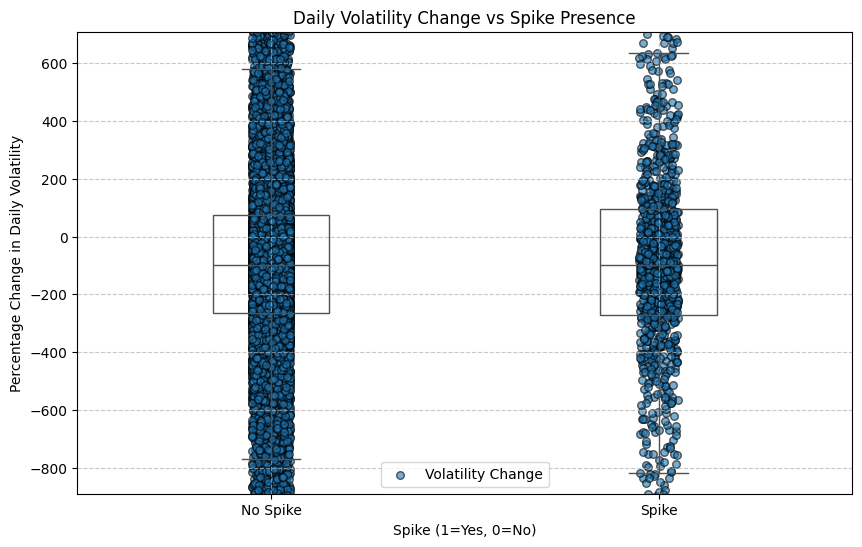

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#x-axis for spike presence (0 or 1)
#y-axis for swings in daily volatility
x = daily_spike_vs_none['Spike'].astype(float).values
y = daily_spike_vs_none['pct_change_daily'].values

# Flatten any nested sequences and convert all to float, setting problematic values to NaN
def clean_value(val):
    if isinstance(val, (list, np.ndarray)):
        return float(val[0]) if len(val) > 0 else np.nan
    try:
        return float(val)
    except:
        return np.nan


y_cleaned = np.array([clean_value(v) for v in daily_spike_vs_none['pct_change_daily']])

# Add jitter for scatter for clearer visualization
x_jitter = x + np.random.uniform(-0.05, 0.05, size=len(x))

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter with transparency and jitter
plt.scatter(x_jitter, y_cleaned, alpha=0.6, s=30, edgecolor='k', label='Volatility Change')

# Boxplot overlaid
sns.boxplot(x=x, y=y_cleaned, whis=1.5, width=0.3, boxprops={'facecolor':'none'}, showfliers=False)

plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Daily Volatility Change vs Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\2771718607.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned', data=df_plot, inner='quartile', palette='Set2')


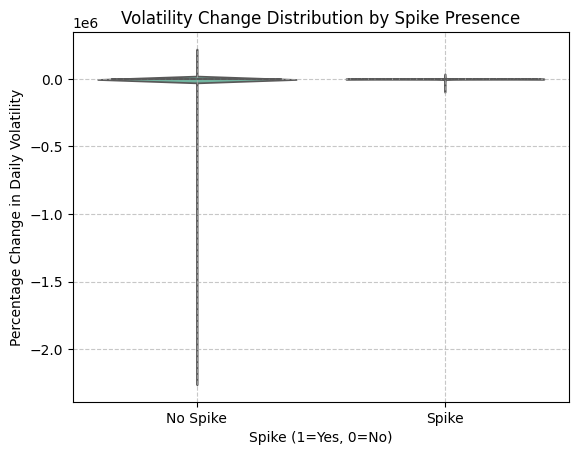

In [19]:
#Visuals of daily volatility change vs spike presence using violin plot
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose your clean y array is named `y_cleaned`
# Ensure the length matches your DataFrame
daily_spike_vs_none['y_cleaned'] = y_cleaned
df_plot = daily_spike_vs_none[['Spike', 'y_cleaned']].dropna()

sns.violinplot(x='Spike', y='y_cleaned', data=df_plot, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\1902914995.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned', data=df_plot, inner='quartile', palette='Set2')


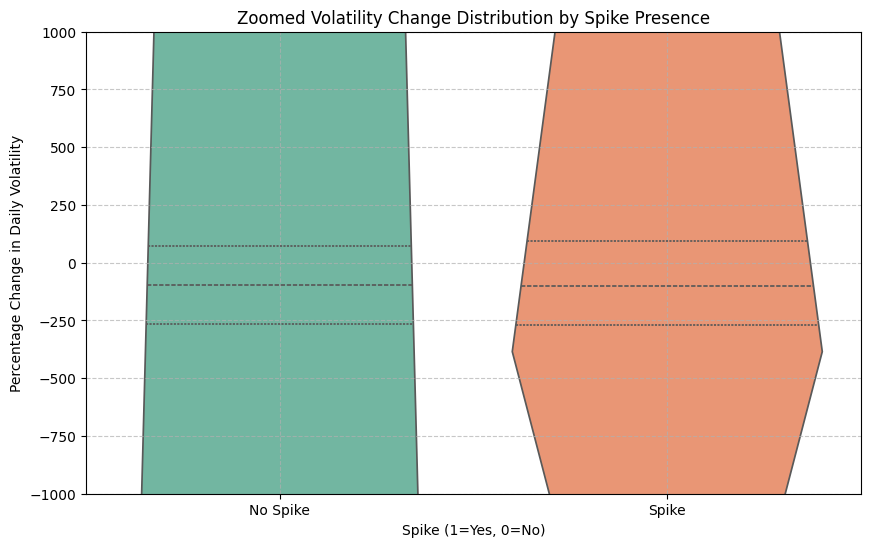

In [20]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Spike', y='y_cleaned', data=df_plot, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Zoomed Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(-1000, 1000)  # Adjust limits to focus on main data
plt.show()

C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\2441235087.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned', data=df_trimmed, inner='quartile', palette='Set2')


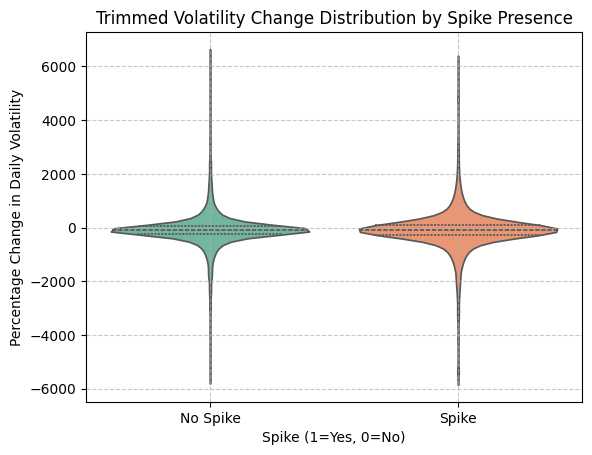

In [21]:
import numpy as np

lower = np.percentile(df_plot['y_cleaned'], 1)
upper = np.percentile(df_plot['y_cleaned'], 99)
df_trimmed = df_plot[(df_plot['y_cleaned'] >= lower) & (df_plot['y_cleaned'] <= upper)]

sns.violinplot(x='Spike', y='y_cleaned', data=df_trimmed, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Trimmed Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [22]:
print("Stats for No Spike:")
print(df_trimmed[df_trimmed['Spike']==0]['y_cleaned'].describe())
print("\nStats for Spike:")
print(df_trimmed[df_trimmed['Spike']==1]['y_cleaned'].describe())


Stats for No Spike:
count    15736.000000
mean       -88.315635
std        830.160787
min      -5576.377282
25%       -257.553076
50%        -97.556272
75%         68.648645
max       6410.359569
Name: y_cleaned, dtype: float64

Stats for Spike:
count    1386.000000
mean     -109.686634
std       884.501180
min     -5446.076316
25%      -267.507349
50%      -100.000000
75%        86.972144
max      5985.789179
Name: y_cleaned, dtype: float64


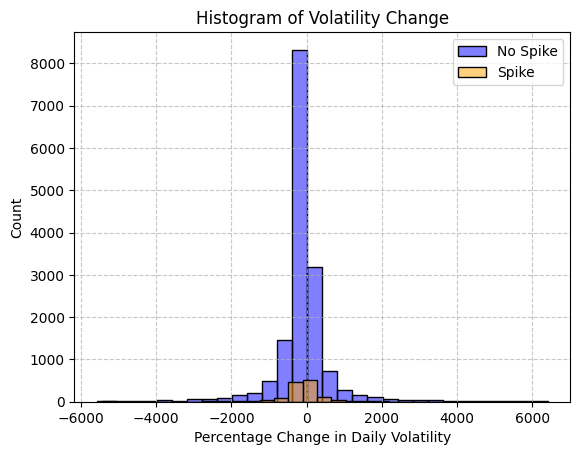

In [23]:
sns.histplot(df_trimmed[df_trimmed['Spike']==0]['y_cleaned'], color='blue', label='No Spike', alpha=0.5, bins=30)
sns.histplot(df_trimmed[df_trimmed['Spike']==1]['y_cleaned'], color='orange', label='Spike', alpha=0.5, bins=30)
plt.legend()
plt.xlabel('Percentage Change in Daily Volatility')
plt.title('Histogram of Volatility Change')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

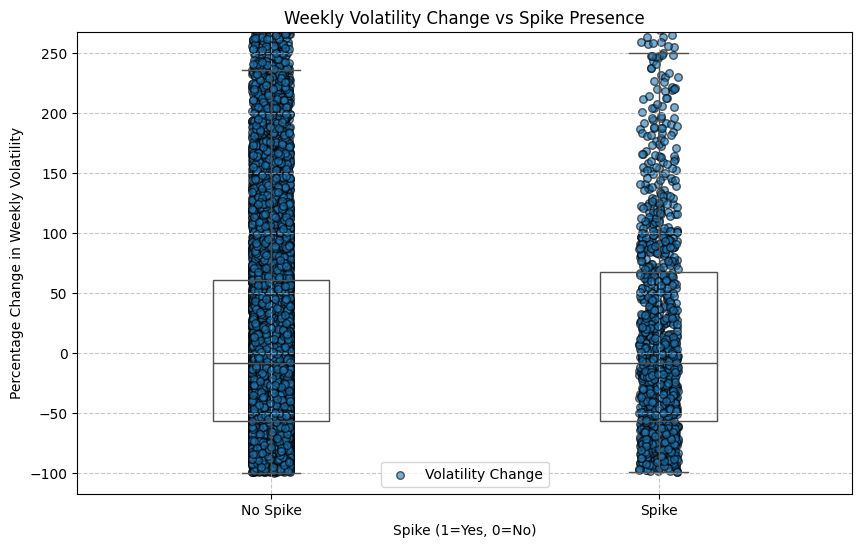

In [24]:
#Box and scatter plot for weekly volatility change vs spike presence
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


x = daily_spike_vs_none['Spike'].astype(float).values
y = daily_spike_vs_none['pct_change_weekly'].values

# Flatten any nested sequences and convert all to float, setting problematic values to NaN
def clean_value(val):
    if isinstance(val, (list, np.ndarray)):
        return float(val[0]) if len(val) > 0 else np.nan
    try:
        return float(val)
    except:
        return np.nan

y_cleaned_weekly = np.array([clean_value(v) for v in daily_spike_vs_none['pct_change_weekly']])

# Add jitter for scatter
x_jitter = x + np.random.uniform(-0.05, 0.05, size=len(x))

plt.figure(figsize=(10, 6))

# Scatter with transparency and jitter
plt.scatter(x_jitter, y_cleaned_weekly, alpha=0.6, s=30, edgecolor='k', label='Volatility Change')

# Boxplot overlaid
sns.boxplot(x=x, y=y_cleaned_weekly, whis=1.5, width=0.3, boxprops={'facecolor':'none'}, showfliers=False)
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Weekly Volatility')
plt.title('Weekly Volatility Change vs Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\595364998.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned_weekly', data=df_plot, inner='quartile', palette='Set2')


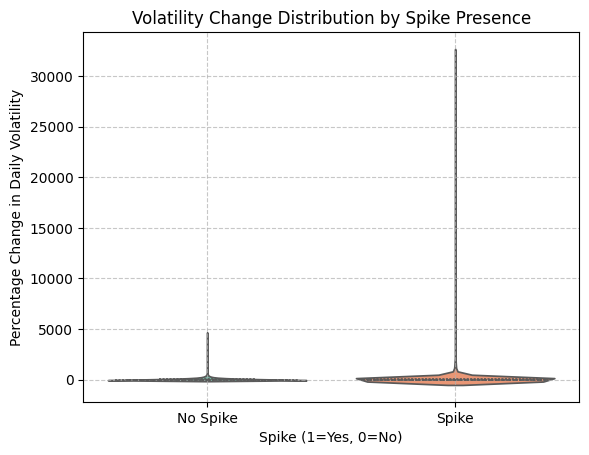

In [25]:
#visuals for week after using violin plot
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose your clean y array is named `y_cleaned`
# Ensure the length matches your DataFrame
daily_spike_vs_none['y_cleaned_weekly'] = y_cleaned_weekly
df_plot = daily_spike_vs_none[['Spike', 'y_cleaned_weekly']].dropna()

sns.violinplot(x='Spike', y='y_cleaned_weekly', data=df_plot, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\1505735702.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned_weekly', data=df_plot, inner='quartile', palette='Set2')


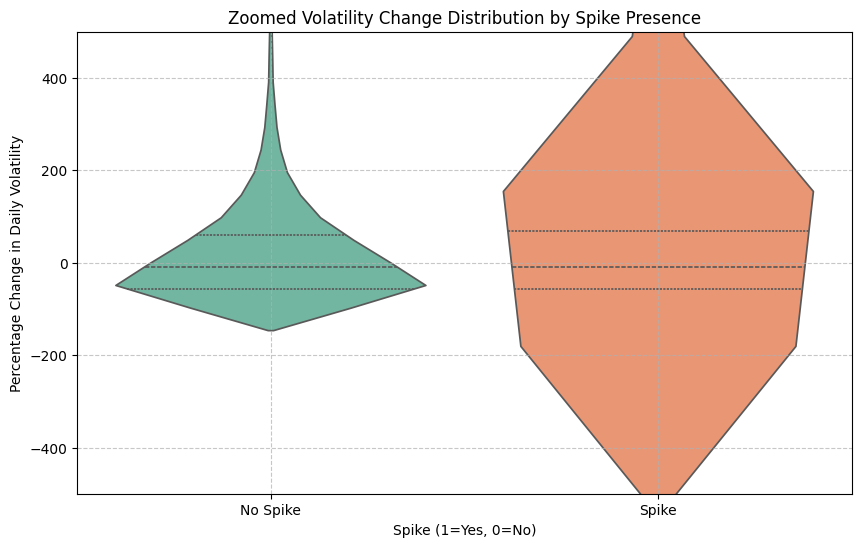

In [26]:
#visuals for week after using violin plot zoomed in
plt.figure(figsize=(10, 6))
sns.violinplot(x='Spike', y='y_cleaned_weekly', data=df_plot, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Zoomed Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(-500, 500)  # Adjust limits to focus on main data
plt.show()

C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\583017894.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned_weekly', data=df_trimmed, inner='quartile', palette='Set2')


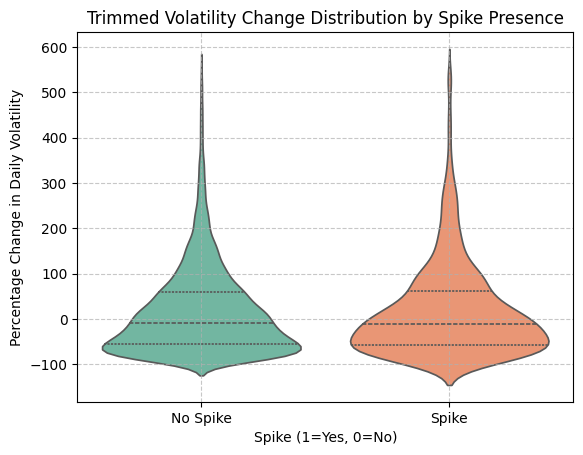

In [27]:
#trimmed violin plot for week after
lower = np.percentile(df_plot['y_cleaned_weekly'], 1)
upper = np.percentile(df_plot['y_cleaned_weekly'], 99)
df_trimmed = df_plot[(df_plot['y_cleaned_weekly'] >= lower) & (df_plot['y_cleaned_weekly'] <= upper)]
sns.violinplot(x='Spike', y='y_cleaned_weekly', data=df_trimmed, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Daily Volatility')
plt.title('Trimmed Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

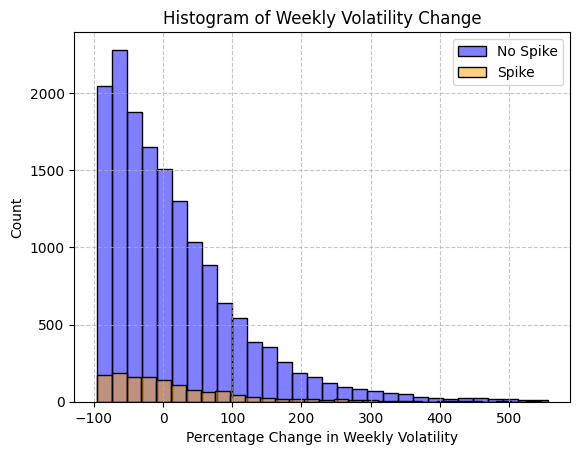

In [28]:
#histogram for week after
sns.histplot(df_trimmed[df_trimmed['Spike']==0]['y_cleaned_weekly'], color='blue', label='No Spike', alpha=0.5, bins=30)
sns.histplot(df_trimmed[df_trimmed['Spike']==1]['y_cleaned_weekly'], color='orange', label='Spike', alpha=0.5, bins=30)
plt.legend()
plt.xlabel('Percentage Change in Weekly Volatility')
plt.title('Histogram of Weekly Volatility Change')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

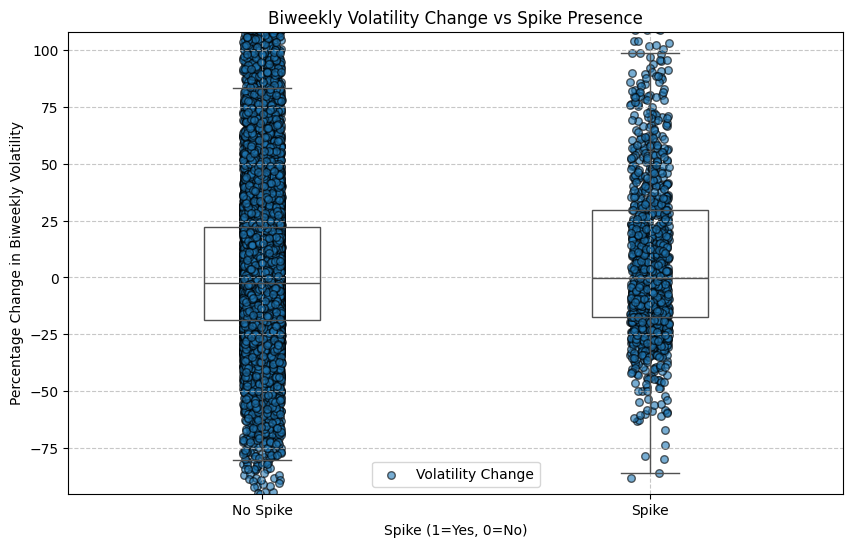

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Repeat for biweekly
x = daily_spike_vs_none['Spike'].astype(float).values
y = daily_spike_vs_none['pct_change_biweekly'].values

# Flatten any nested sequences and convert all to float, setting problematic values to NaN
def clean_value(val):
    if isinstance(val, (list, np.ndarray)):
        return float(val[0]) if len(val) > 0 else np.nan
    try:
        return float(val)
    except:
        return np.nan

y_cleaned_biweekly = np.array([clean_value(v) for v in daily_spike_vs_none['pct_change_biweekly']])

# Add jitter for scatter
x_jitter = x + np.random.uniform(-0.05, 0.05,
    size=len(x))

plt.figure(figsize=(10, 6))


# Scatter with transparency and jitter
plt.scatter(x_jitter, y_cleaned_biweekly, alpha=0.6, s=30, edgecolor='k', label='Volatility Change')

# Boxplot overlaid
sns.boxplot(x=x, y=y_cleaned_biweekly, whis=1.5, width=0.3, boxprops={'facecolor':'none'}, showfliers=False)
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Biweekly Volatility')
plt.title('Biweekly Volatility Change vs Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\2296933421.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned_biweekly', data=df_plot, inner='quartile', palette='Set2')


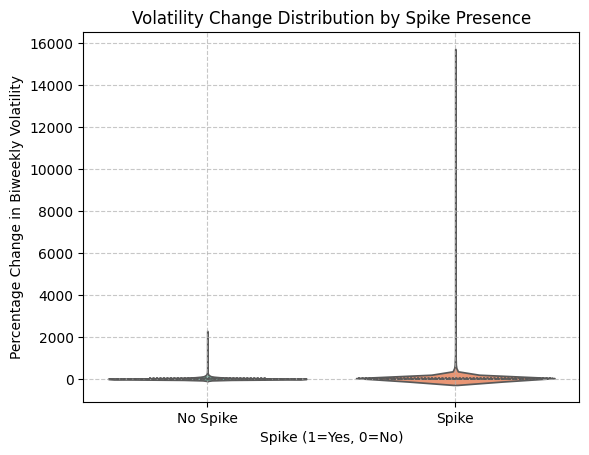

In [30]:
#Visuals for biweek after using violin plot
import matplotlib.pyplot as plt
import seaborn as sns
# Suppose your clean y array is named `y_cleaned`
# Ensure the length matches your DataFrame
daily_spike_vs_none['y_cleaned_biweekly'] = y_cleaned_biweekly
df_plot = daily_spike_vs_none[['Spike', 'y_cleaned_biweekly']].dropna()
sns.violinplot(x='Spike', y='y_cleaned_biweekly', data=df_plot, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Biweekly Volatility')
plt.title('Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\1261922722.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned_biweekly', data=df_plot, inner='quartile', palette='Set2')


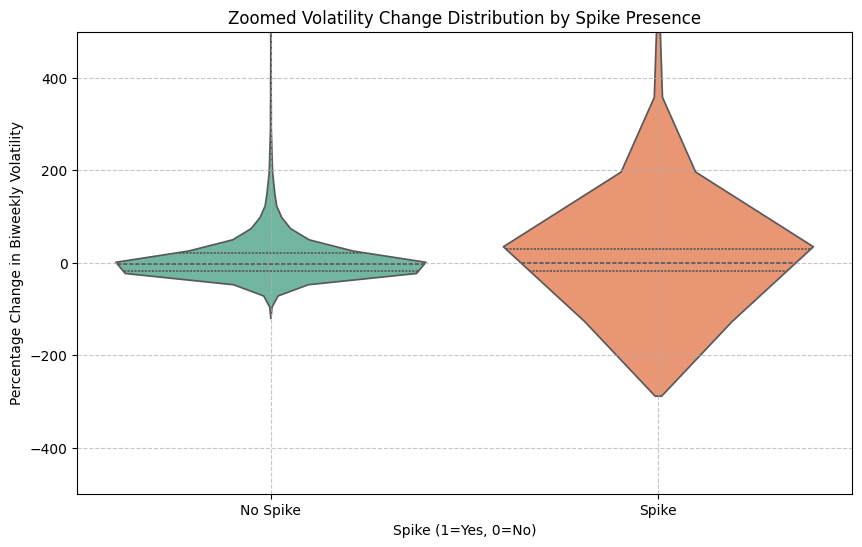

In [31]:
#Zoomed violin plot for biweek after
plt.figure(figsize=(10, 6))
sns.violinplot(x='Spike', y='y_cleaned_biweekly', data=df_plot, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Biweekly Volatility')
plt.title('Zoomed Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(-500, 500)  # Adjust limits to focus on main data
plt.show()


C:\Users\Thisu\AppData\Local\Temp\ipykernel_6944\1047501010.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Spike', y='y_cleaned_biweekly', data=df_trimmed, inner='quartile', palette='Set2')


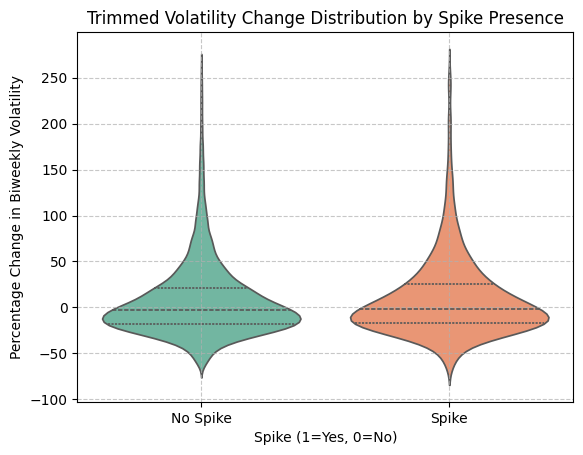

In [33]:
#Repeat for biweekly trimmed violin plot for biweek after
import numpy as np
lower = np.percentile(df_plot['y_cleaned_biweekly'], 1)
upper = np.percentile(df_plot['y_cleaned_biweekly'], 99)
df_trimmed = df_plot[(df_plot['y_cleaned_biweekly'] >= lower) & (df_plot['y_cleaned_biweekly'] <= upper)]
sns.violinplot(x='Spike', y='y_cleaned_biweekly', data=df_trimmed, inner='quartile', palette='Set2')
plt.xlabel('Spike (1=Yes, 0=No)')
plt.ylabel('Percentage Change in Biweekly Volatility')
plt.title('Trimmed Volatility Change Distribution by Spike Presence')
plt.xticks([0, 1], ['No Spike', 'Spike'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


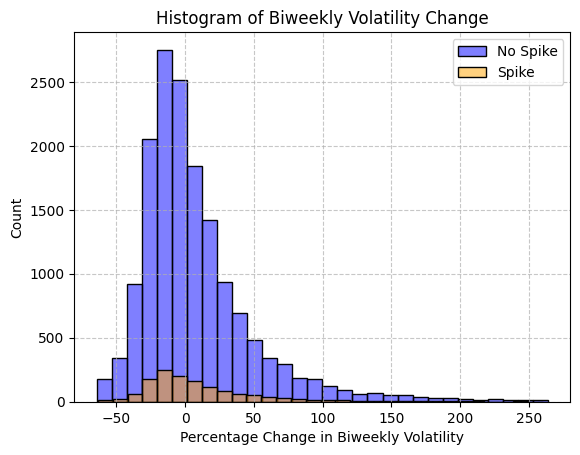

In [34]:
#Histogram for biweek after
sns.histplot(df_trimmed[df_trimmed['Spike']==0]['y_cleaned_biweekly'], color='blue', label='No Spike', alpha=0.5, bins=30)
sns.histplot(df_trimmed[df_trimmed['Spike']==1]['y_cleaned_biweekly'], color='orange', label='Spike', alpha=0.5, bins=30)
plt.legend()
plt.xlabel('Percentage Change in Biweekly Volatility')
plt.title('Histogram of Biweekly Volatility Change')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [35]:
#Statistics for biweek after
print("Stats for No Spike:")
print(df_trimmed[df_trimmed['Spike']==0]['y_cleaned_biweekly'].describe())
print("\nStats for Spike:")
print(df_trimmed[df_trimmed['Spike']==1]['y_cleaned_biweekly'].describe())


Stats for No Spike:
count    15751.000000
mean         7.770270
std         42.284875
min        -64.036354
25%        -18.481669
50%         -2.547463
75%         21.542641
max        263.667310
Name: y_cleaned_biweekly, dtype: float64

Stats for Spike:
count    1371.000000
mean       10.691372
std        44.729860
min       -63.317063
25%       -17.498380
50%        -1.610553
75%        25.543541
max       260.260343
Name: y_cleaned_biweekly, dtype: float64
